# Aula 25 — **Embeddings** e Modelo de Linguagem (Resumo)

Este notebook resume a Aula 25 com **Markdown** (teoria) e **R** (código).  
Conectamos o modelo estatístico **multinomial** ao modelo neural com **embeddings**.

## 1) Do modelo multinomial ao modelo neural

Para uma sequência de tokens $x_{1:k}$ de um vocabulário fixo $V$, o modelo de linguagem é

$$
P_\theta(x_{1:k}) \;=\; \prod_{s=1}^{k} P_\theta(x_s \mid x_{1:s-1}).
$$

Cada $P_\theta(\cdot \mid \text{contexto})$ é uma **distribuição multinomial** sobre $V$.

## 2) Vocabulário e representação one-hot

Cada token $t \in \{1,\dots,V\}$ pode ser codificado como vetor **one-hot** $e_t \in \mathbb{R}^V$.
Essa representação é ortogonal e **não contém semelhança** entre palavras — por isso introduzimos *embeddings*.

In [1]:
# Configuração básica
set.seed(7)
V <- 8         # tamanho do vocabulário
m <- 4         # dimensão do embedding

# Vetores one-hot
one_hot <- function(t, V) {
  v <- rep(0, V); v[t] <- 1; matrix(v, nrow = 1)
}

# Exemplo de alguns tokens (1..V)
tokens_demo <- 1:4
hots <- do.call(rbind, lapply(tokens_demo, one_hot, V = V))
hots

1,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0
0,0,1,0,0,0,0,0
0,0,0,1,0,0,0,0


## 3) Embeddings: de símbolos para geometria

Definimos uma matriz $A \in \mathbb{R}^{V \times m}$.  
O *embedding* de um token $t$ é simplesmente:
$$
x_t = e_t A \in \mathbb{R}^m.
$$

Duas palavras com contextos parecidos devem ficar **próximas** no espaço vetorial (alta similaridade cosseno).

In [2]:
# Matriz de embeddings A (inicialização aleatória para demonstração)
A <- matrix(rnorm(V * m, sd = 0.5), nrow = V, ncol = m)

embed_tokens <- function(tokens, A) {
  # tokens: vetor de índices inteiros
  A[tokens, , drop = FALSE]
}

X <- embed_tokens(tokens_demo, A)
X

1.1436236,0.07632881,-0.446900362,0.63645843
-0.5983858,1.09498905,-0.153664150,0.09209639
-0.3471463,0.17849312,-0.002411211,0.37613995
-0.2061465,1.35837589,0.494082075,0.29587253


### Similaridade entre embeddings

Usamos a **semelhança cosseno** para medir proximidade no espaço contínuo.

In [3]:
cos_sim <- function(M) {
  # similaridade cosseno entre linhas de M
  nr <- nrow(M)
  S <- matrix(0, nr, nr)
  for (i in 1:nr) {
    for (j in 1:nr) {
      S[i, j] <- sum(M[i,] * M[j,]) / (sqrt(sum(M[i,]^2)) * sqrt(sum(M[j,]^2)))
    }
  }
  S
}

S <- cos_sim(X)
S

1.00000000,-0.2711560,-0.1903266,-0.07975289
-0.27115598,1.0000000,0.6412203,0.83178234
-0.19032665,0.6412203,1.0000000,0.52518283
-0.07975289,0.8317823,0.5251828,1.00000000


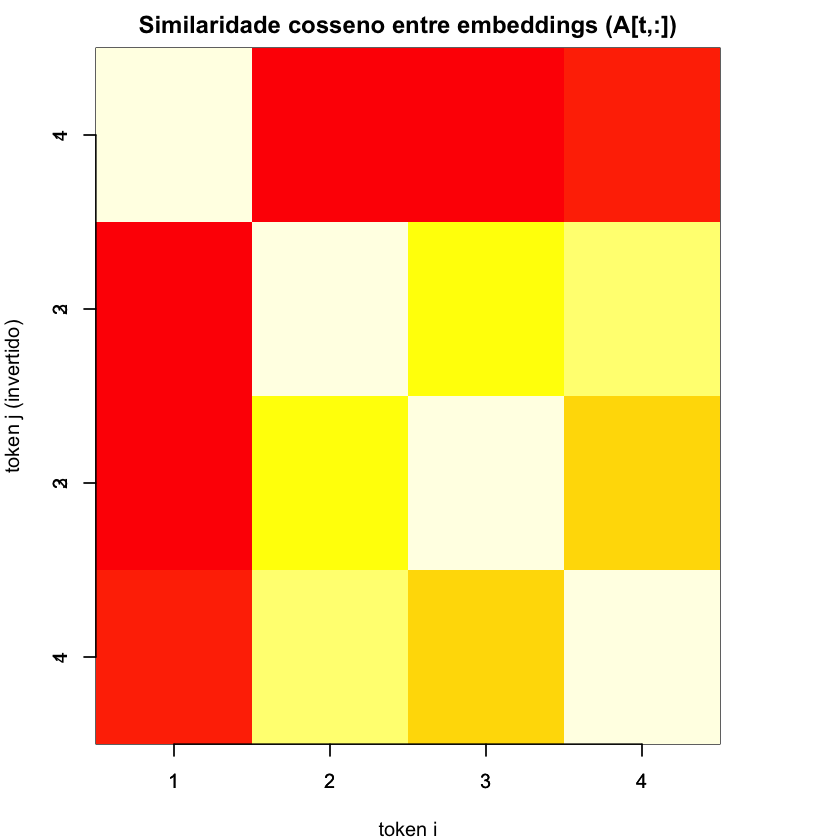

In [4]:
# Visualização rápida (heatmap base R)
op <- par(no.readonly = TRUE)
par(mar = c(4,4,2,5))
image(1:nrow(S), 1:ncol(S), t(S[nrow(S):1, ]),
      xlab = "token i", ylab = "token j (invertido)",
      main = "Similaridade cosseno entre embeddings (A[t,:])",
      col = heat.colors(20))
axis(1, at = 1:nrow(S), labels = tokens_demo)
axis(2, at = 1:ncol(S), labels = rev(tokens_demo))
par(op)

## 4) Sequência, posição e tokens especiais

- O vocabulário inclui símbolos como `<pad>`, `<unk>`, `<eos>` (tratados como quaisquer outros no embedding).
- Opcionalmente somamos um **vetor de posição** $P \in \mathbb{R}^{k \times m}$ para codificar ordem.

Aqui criaremos uma **sequência toy** de 6 tokens e somaremos uma posição linear simples.

In [5]:
k <- 6
seq_tokens <- c(1, 3, 2, 5, 7, 8)  # sequência de índices no vocabulário
X_seq <- embed_tokens(seq_tokens, A)    # k x m

# posição linear simples (apenas para demonstração)
P <- matrix(seq(0, 1, length.out = k), nrow = k, ncol = m)
X_pos <- X_seq + P

X_seq
X_pos

1.14362358,0.07632881,-0.446900362,0.63645843
-0.34714626,0.17849312,-0.002411211,0.37613995
-0.59838584,1.09498905,-0.153664150,0.09209639
-0.48533667,1.14072596,0.419875180,-0.49152630
0.37406967,0.94803353,0.652982360,-0.43542551
-0.05847761,0.23384026,-0.693998108,0.35935528


1.1436236,0.07632881,-0.4469004,0.6364584
-0.1471463,0.37849312,0.1975888,0.5761399
-0.1983858,1.49498905,0.2463359,0.4920964
0.1146633,1.74072596,1.0198752,0.1084737
1.1740697,1.74803353,1.4529824,0.3645745
0.9415224,1.23384026,0.3060019,1.3593553


## 5) Cabeça multinomial (regressão para o próximo token)

Com embeddings, uma camada linear $B \in \mathbb{R}^{m \times V}$ seguida de *softmax* modela
$$
P_\theta(x_{s+1} = i \mid x_{1:s}) \approx \mathrm{softmax}( h_s B )_i,
$$
onde $h_s$ é uma representação do contexto (aqui usamos a **média dos embeddings até s** como proxy simples).

In [6]:
softmax_row <- function(C) {
  Cs <- sweep(C, 1, apply(C, 1, max), FUN = "-")
  E <- exp(Cs)
  sweep(E, 1, rowSums(E), FUN = "/")
}

# Parâmetros da "cabeça" multinomial
B <- matrix(rnorm(m * V, sd = 0.3), nrow = m, ncol = V)

# Representação de contexto: média cumulativa dos embeddings (toy)
ctx_mat <- matrix(0, nrow = k, ncol = m)
for (s in 1:k) {
  ctx_mat[s, ] <- colMeans(X_pos[1:s, , drop = FALSE])
}

# Distribuições previstas para o próximo token
logits <- ctx_mat %*% B         # k x V
probs  <- softmax_row(logits)   # cada linha soma 1

# Mostramos as três primeiras linhas (passos 1,2,3)
round(probs[1:3, ], 3)

0.118,0.178,0.145,0.097,0.131,0.141,0.058,0.131
0.114,0.141,0.112,0.120,0.134,0.155,0.084,0.140
0.108,0.111,0.092,0.119,0.145,0.187,0.097,0.141


## 6) Verossimilhança da sequência e *cross-entropy*

Dada a sequência $x_{1:k}$, a verossimilhança autoregressiva é
$$
\mathcal{L}(\theta) = \prod_{s=1}^{k-1} P_\theta(x_{s+1} \mid x_{1:s}).
$$
No treino, maximizamos $\log \mathcal{L}$ (equivalente a minimizar a *cross-entropy*).

In [7]:
# Calcula log-verossimilhança para a nossa sequência (usando probs preditas para o próximo token)
target_next <- seq_tokens[-1]         # x_{2..k}
pred_rows   <- probs[1:(k-1), ]       # previsões nos passos 1..k-1

ll <- 0
for (s in 1:(k-1)) {
  ll <- ll + log(pred_rows[s, target_next[s]] + 1e-12)
}
ll  # log-verossimilhança da sequência toy

[1] -10.08658

## 7) Takeaways

- **One-hot** é simbólico e não tem geometria; **embeddings** criam um espaço contínuo onde “proximidade = semelhança”.
- O modelo de linguagem é **multinomial condicional**; redes neurais aprendem esse condicional via camadas lineares e *attention*.
- Tokens especiais (`<pad>`, `<unk>`, `<eos>`) também possuem vetores no embedding e têm função estrutural.
- A **verossimilhança** do texto se decompõe no produto das probabilidades condicionais do próximo token.
- Embeddings + (posicional) + *attention* = núcleo do Transformer usado em GPTs.

|